In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
from matplotlib import collections  as mc

In [2]:
import sys
sys.executable
from mpl_toolkits.basemap import Basemap


In [ ]:
#getting started https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html

/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


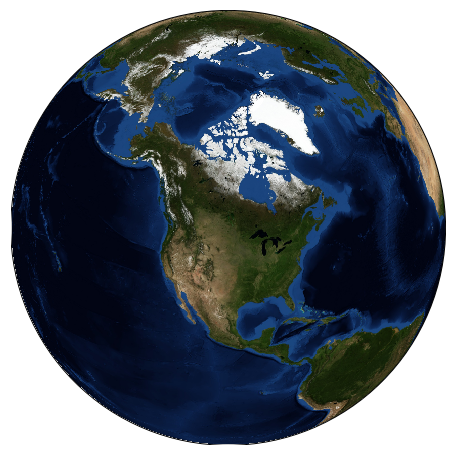

In [23]:
plt.figure(figsize=(8, 8))
m = Basemap(projection='ortho', resolution=None, lat_0=50, lon_0=-100)
m.bluemarble(scale=0.5);
print("")

## Prepare Tow Data; coordinates to floats, calculate bounding box

In [3]:
#read in points from file
df1 = pd.read_csv('../data/raw/IBS2_First_2_Years/Tow_Info.csv')
df2 = pd.read_csv('../data/raw/IBS2_First_2_Years/tow_info_201880.csv')
tow_df = df1.append( df2, ignore_index=True ).dropna()

tow_df['slon'] =  tow_df.apply(lambda row: float((row["START_LON"]).replace('W','')) / -100, axis=1) 
tow_df['slat'] =  tow_df.apply(lambda row: float((row["START_LAT"]).replace('N','')) / 100, axis=1) 
tow_df['elon'] =  tow_df.apply(lambda row: float((row["END_LON"]).replace('W','')) / -100, axis=1) 
tow_df['elat'] =  tow_df.apply(lambda row: float((row["END_LAT"]).replace('N','')) / 100, axis=1) 
tow_df['pdate'] = tow_df.apply(lambda row: pd.to_datetime( row['START_TIME'] ), axis=1 )
tow_df['month'] = tow_df.apply(lambda row: row['pdate'].month , axis=1 )


tow_df['dist'] = ((tow_df['slon'] - tow_df['elon'])**2 + (tow_df['slat'] - tow_df['elat'])**2) ** 0.5
tow_df = tow_df.loc[tow_df['dist'] < .1]

lats = [ i for i in tow_df['slat'] ]
lons = [ i for i in tow_df['slon'] ]

llcrnrlon = min(lons)
llcrnrlat = min(lats)
urcrnrlon = max(lons)
urcrnrlat = max(lats)
box = [ llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat ]
print(box)


[-70.51364, 41.47909, -69.30295, 43.438689999999994]


In [4]:
def get_zone( obj ):
    coords = [ (obj['slat'] + obj['elat'])/2 , (obj['slon'] + obj['elon'])/2 ]    
    if coords[0] < 41.72:
        return 3
    if coords[0] > 42.75:
        if coords[1] > -69.77:
            zone=1
        else:
            zone=5
    else:
        if coords[1] > -69.77:
            zone=2        
        else:
            zone=4
    return zone

tow_df['zone'] = tow_df.apply(lambda row: get_zone(row) , axis=1 )

#tow_df[ tow_df['zone'] == 3]


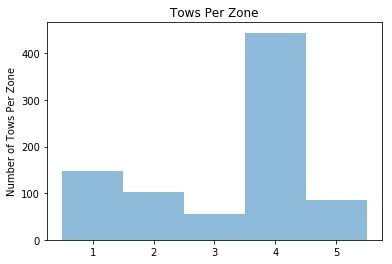

In [5]:
#show dist of tows by zone
y_pos = np.arange(1,6)
tows = []
bar_width =1
for zone in range(1,6):
    tows.append( len([ i for i in tow_df['zone'] if i == zone]))
plt.bar(y_pos, tows, bar_width, align='center', alpha=0.5)
plt.xticks(y_pos, y_pos)
plt.ylabel('Number of Tows Per Zone')
plt.title('Tows Per Zone')
plt.savefig( '../data/raw/Tow_zone_distribution.png')
plt.show()

In [6]:
def winter( obj ):
    if obj['month'] == 1 or obj['month'] > 9:
        return 1
    else:
        return 0
tow_df['winter'] = tow_df.apply(lambda row: winter(row) , axis=1 )

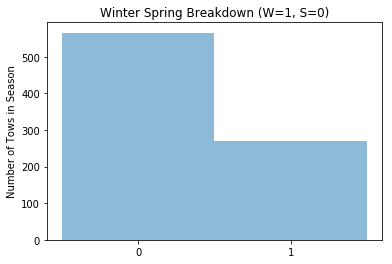

In [7]:
#show dist of tows by zone
y_pos = np.arange(0,2)
tows = []
bar_width =1
for w in range(0,2):
    tows.append( len([ i for i in tow_df['winter'] if i == w]))
plt.bar(y_pos, tows, bar_width, align='center', alpha=0.5)
plt.xticks(y_pos, y_pos)
plt.ylabel('Number of Tows in Season')
plt.title('Winter Spring Breakdown (W=1, S=0)')
plt.savefig( '../data/raw/winter_spring_distribution.png')
plt.show()

In [9]:
tow_df = tow_df[tow_df['dist'] < .1]

### lookup sea surface temperature and bathymetry data

In [8]:
import subprocess

def get_sst( obj ):
    date = tuple([ obj["pdate"].year, obj["pdate"].month])
    coords = [ str((obj['slat'] + obj['elat'])/2) , str((obj['slon'] + obj['elon'])/2 ) ]
    
    sstfile = "../data/raw/aquaMODIS-L2-sst/{}-{}.tiff".format( date[0], str(date[1]).zfill(2) )
    
    test = subprocess.Popen(["gdallocationinfo",
                            "-valonly",
                            "-wgs84",
                            sstfile,
                            coords[1],
                            coords[0]
                            ], stdout=subprocess.PIPE)  
    output = test.communicate()
    val = float(output[0].decode("utf-8"))
    cel = ((val / 255) * 47) -2
    
    return cel

def get_bth( obj ):
    try:
        coords = [ str((obj['slat'] + obj['elat'])/2) , str((obj['slon'] + obj['elon'])/2 ) ]
        test = subprocess.Popen(["gdallocationinfo",
                            "-valonly",
                            "-wgs84",
                            "../data/raw/bathymetry/bathymetry.tif",
                            coords[1],
                            coords[0]
                            ], stdout=subprocess.PIPE)  
        output = test.communicate()
        bth = float(output[0].decode("utf-8"))
        return bth if bth <= 0 else 0
    except:
        return 400

#chlorophyll unit milligrams / square meter 
def get_chlorophyll( obj ):
    date = tuple([ obj["pdate"].year, obj["pdate"].month])
    coords = [ str((obj['slat'] + obj['elat'])/2) , str((obj['slon'] + obj['elon'])/2 ) ]
    
    file = "../data/raw/aquaMODIS-chlorophyll/{}-{}.tiff".format( date[0], str(date[1]).zfill(2) )
    
    test = subprocess.Popen(["gdallocationinfo",
                            "-valonly",
                            "-wgs84",
                            file,
                            coords[1],
                            coords[0]
                            ], stdout=subprocess.PIPE)  
    output = test.communicate()
    val = float(output[0].decode("utf-8"))
    if val == 255:
        return None
    
    cel = 10 ** (((val + 1) / 256 * 4) -2) 
    return cel

tow_df['sst'] =  tow_df.apply(lambda row: get_sst( row ), axis=1)
tow_df['bth'] =  tow_df.apply(lambda row: get_bth( row ), axis=1) 
tow_df['chl'] =  tow_df.apply(lambda row: get_chlorophyll( row ), axis=1) 

###tow_df.head()

### read in fish data; append tow data to fish records

In [9]:
fish_df = pd.read_csv('../data/raw/reorg9-18-2018.csv').dropna()
fish_df.count()

OPERATION_ID    2962
ORGANISM_ID     2962
CRUISE_ID       2962
length          2962
sex             2962
maturity        2962
dtype: int64

In [10]:
fishtow_df = pd.merge(fish_df, tow_df, how='left', on=['OPERATION_ID', 'CRUISE_ID'] )
fishtow_df.count()

OPERATION_ID        2962
ORGANISM_ID         2962
CRUISE_ID           2962
length              2962
sex                 2962
maturity            2962
OPERATION_STATUS    2855
SITE_NAME           2855
START_TIME          2855
START_LAT           2855
START_LON           2855
END_TIME            2855
END_LAT             2855
END_LON             2855
slon                2855
slat                2855
elon                2855
elat                2855
pdate               2855
month               2855
dist                2855
zone                2855
winter              2855
sst                 2855
bth                 2855
chl                 2493
dtype: int64

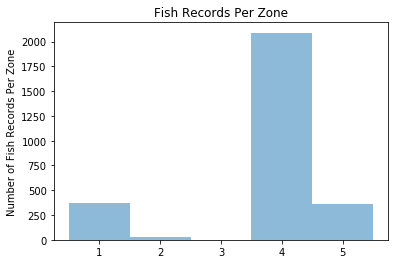

In [11]:
#show dist of tows by zone
y_pos = np.arange(1,6)
tows = []
bar_width =1
for zone in range(1,6):
    tows.append( len([ i for i in fishtow_df['zone'] if i == zone]))
plt.bar(y_pos, tows, bar_width, align='center', alpha=0.5)
plt.xticks(y_pos, y_pos)
plt.ylabel('Number of Fish Records Per Zone')
plt.title('Fish Records Per Zone')
plt.savefig( '../data/raw/fish_rec_dist.png')
plt.show() 

In [12]:
fishtow_df = fishtow_df[fishtow_df['sst'] < 44]
fishtow_df = fishtow_df[fishtow_df['chl'] < 14]

valid_sex = ['M', 'F']
fishtow_df = fishtow_df.loc[fishtow_df['sex'].isin(valid_sex)]

print( set([i for i in fishtow_df['sex']]) )

fishtow_df.count()


set(['M', 'F'])


OPERATION_ID        2251
ORGANISM_ID         2251
CRUISE_ID           2251
length              2251
sex                 2251
maturity            2251
OPERATION_STATUS    2251
SITE_NAME           2251
START_TIME          2251
START_LAT           2251
START_LON           2251
END_TIME            2251
END_LAT             2251
END_LON             2251
slon                2251
slat                2251
elon                2251
elat                2251
pdate               2251
month               2251
dist                2251
zone                2251
winter              2251
sst                 2251
bth                 2251
chl                 2251
dtype: int64

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


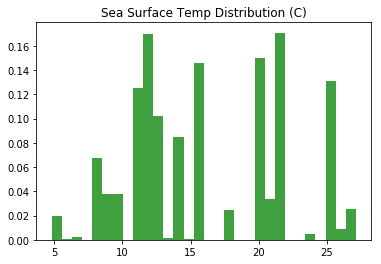

In [13]:
plt.hist( fishtow_df['sst'], 30, normed=1, facecolor='green', alpha=0.75)
plt.title('Sea Surface Temp Distribution (C)')
plt.savefig( '../data/raw/sst-dist.png' )
plt.show()

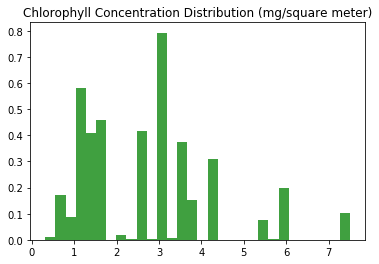

In [14]:
plt.hist( fishtow_df['chl'].dropna(), 30, normed=1, facecolor='green', alpha=0.75)
plt.title('Chlorophyll Concentration Distribution (mg/square meter)')
plt.savefig( '../data/raw/chl-dist.png' )
plt.show()

set(['Resting', 'Ripe', 'Developing', 'Spent', 'Immature', 'Ripe & Running'])


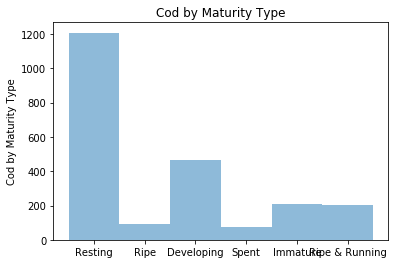

In [15]:
print( set([i for i in fishtow_df['maturity']]) )

#maturity of fish
y_pos = list(set([i for i in fishtow_df['maturity']]))
bar_width =1
count = []
for mat in y_pos:
    count.append( len([ i for i in fishtow_df['maturity'] if i == mat]))
plt.bar(y_pos, count, bar_width, align='center', alpha=0.5)
plt.xticks(y_pos, y_pos)
plt.ylabel('Cod by Maturity Type')
plt.title('Cod by Maturity Type')
plt.savefig( '../data/raw/fish_maturity_dist.png')
plt.show() 

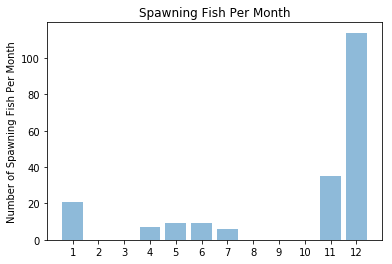

In [30]:
#months that cod are spawning
fishtow_df = fishtow_df[ fishtow_df['maturity'] == 'Ripe & Running']

fishtow_df.count()

# df = df[df['sex'] == 'M']

bar_width = -1
y_pos = np.arange(1,13)
bar_width =1
fish = []

#print( fishtow_df['month'] )

for this_month in range(1,13):
    fish.append( len([ int(i) for i in fishtow_df['month'] if int(i) == this_month]))


plt.bar(y_pos, fish, align='center', alpha=0.5)
plt.xticks(y_pos, y_pos)
plt.ylabel('Number of Spawning Fish Per Month')
plt.title('Spawning Fish Per Month')
plt.savefig( '../data/raw/month_routes/fish_spawning_by_month_distribution.png')
plt.show()





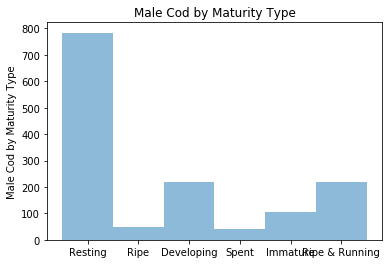

In [34]:

fishtow_df = fishtow_df[fishtow_df['sex'] == 'M']

#maturity of fish
y_pos = list(set([i for i in fishtow_df['maturity']]))
bar_width =1
count = []
for mat in y_pos:
    count.append( len([ i for i in fishtow_df['maturity'] if i == mat]))
plt.bar(y_pos, count, bar_width, align='center', alpha=0.5)
plt.xticks(y_pos, y_pos)
plt.ylabel('Male Cod by Maturity Type')
plt.title('Male Cod by Maturity Type')
plt.savefig( '../data/raw/male_cod_maturity_dist.png')
plt.show() 

### write dataframe to csv for ml step

In [29]:
#write dataframe to csv for ml step
def label_rec_multi( obj ):
    mat = obj['maturity']   
    if mat == 'Ripe & Running':
        return 4
    elif mat == 'Ripe':
        return 3
    elif mat == 'Developing':
        return 2
    elif mat == 'Spent':
        return 1
    else:
        return 0
    
def label_rec_bin( obj ):
    mat = obj['maturity']   
    if mat == 'Ripe & Running':
        return 1
    else:
        return 0

fishtow_df['label-bin'] = fishtow_df.apply(lambda row: label_rec_bin(row), axis=1 )
fishtow_df['label-multi'] = fishtow_df.apply(lambda row: label_rec_multi(row), axis=1 )

eda_outfile = '../data/processed/fishtow-eda.csv'
fishtow_df.to_csv(eda_outfile, sep=',', encoding='utf-8')

ml_df = fishtow_df.drop(['OPERATION_STATUS', 'SITE_NAME',
                        'START_TIME', 'START_LON', 'START_LAT',
                         'END_TIME', 'END_LAT', 'END_LON','dist',
                         'OPERATION_ID', 'CRUISE_ID', 
                         ###maybe add back - see notes
                         'slon','slat','elon','elat','pdate'
                        ], axis=1).dropna()
ml_df.head()
ml_outfile = '../data/processed/fishtow-ml.csv'
ml_df.to_csv(ml_outfile, sep=',', encoding='utf-8')

#### distribution of tows distances, remove erroneous data

/home/local/AZVA-INT/lmckinstry/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


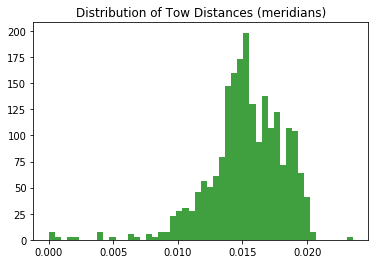

In [65]:
tow_df['dist'] = ((tow_df['slon'] - tow_df['elon'])**2 + (tow_df['slat'] - tow_df['elat'])**2) ** 0.5
(min(tow_df['dist']), max(tow_df['dist']), sum(tow_df['dist'])/len(tow_df['dist'])  )

plt.hist(tow_df['dist'], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('Distribution of Tow Distances (meridians)')
plt.savefig( '../data/raw/Tow_Distance_hist.png' )
plt.show()


In [4]:
#explore dates

dates = [ tuple([i.year, i.month]) for i in tow_df['pdate']]
d_set = list(set(dates))
sort = sorted(d_set, key = lambda x: (x[0], x[1]))
sort


[(2016, 4),
 (2016, 5),
 (2016, 6),
 (2016, 7),
 (2016, 10),
 (2016, 11),
 (2016, 12),
 (2017, 1),
 (2017, 4),
 (2017, 5),
 (2017, 6),
 (2017, 7),
 (2017, 10),
 (2017, 11),
 (2017, 12),
 (2018, 1),
 (2018, 4),
 (2018, 5),
 (2018, 6),
 (2018, 7)]

### plot all tows

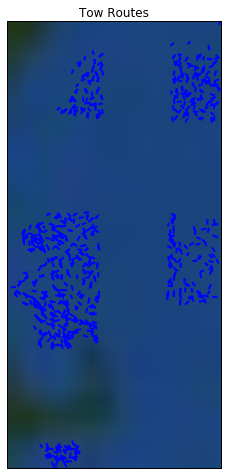

In [20]:

def get_arc( row ):
    return ( 
        row['slon'], row['slat'], row['elon'], row['elat'] )

fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='cass', resolution='i', llcrnrlon=box[0], llcrnrlat=box[1],
            urcrnrlon=box[2], urcrnrlat=box[3], 
            width=8E6, height=8E6, 
            lat_0=43.260511, lon_0=-68.299058,)  #43.260511, -68.299058
m.bluemarble()
#m.drawcoastlines()

# Map (long, lat) to (x, y) for plotting
#plt.plot()

for index, row in tow_df.iterrows():
    try:
        arc = get_arc(row)
        
        m.drawgreatcircle(arc[0],arc[1],arc[2],arc[3],linewidth=2,color='b')
    except:
        pass

#x, y = m(lons, lats)
#plt.plot(x, y, 'ok', markersize=5)
plt.title('Tow Routes')

plt.savefig( '../data/raw/Tow_Routes_zoomin.png' )
#plt.text(x, y, ' Seattle', fontsize=12);
plt.show()

### plot tows by month

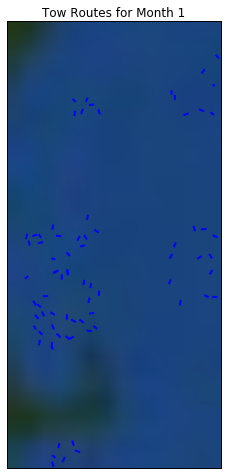

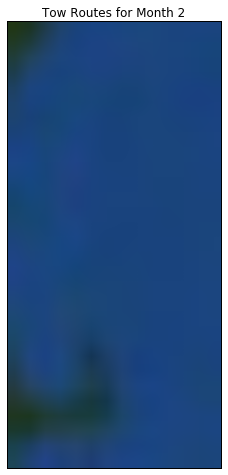

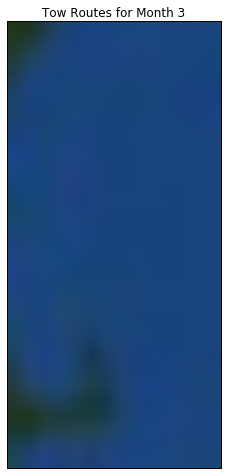

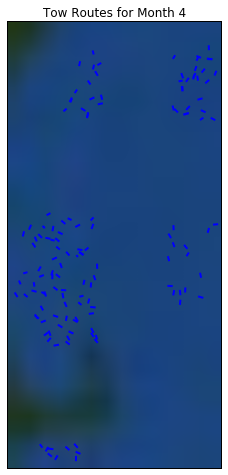

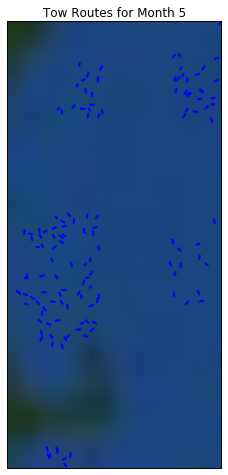

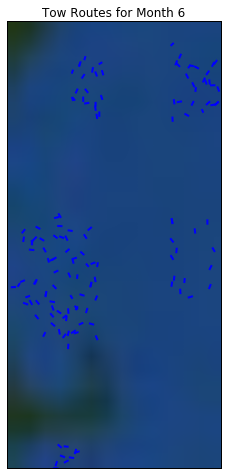

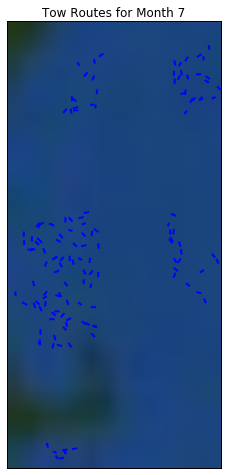

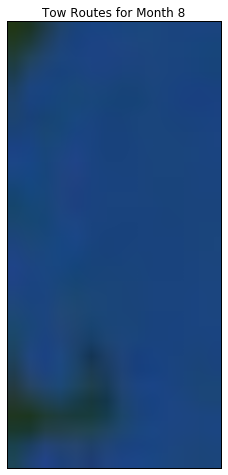

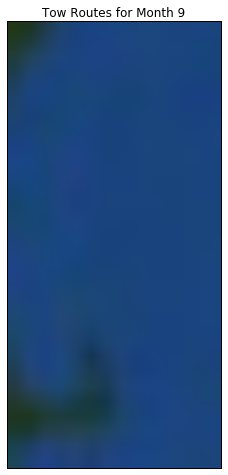

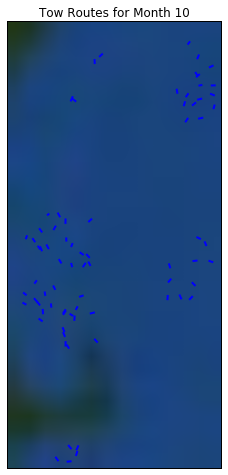

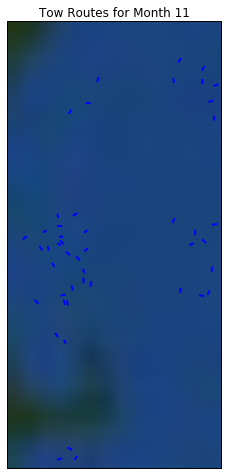

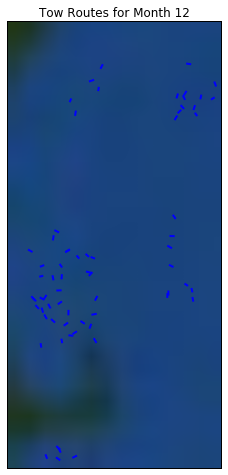

In [48]:
#Color by month
#m.drawcoastlines()
# Map (long, lat) to (x, y) for plotting
#plt.plot()

for this_month in range(1,13):
    fig = plt.figure(figsize=(8, 8))
    m = Basemap(projection='cass', resolution='i', llcrnrlon=box[0], llcrnrlat=box[1],
                urcrnrlon=box[2], urcrnrlat=box[3], 
                width=8E6, height=8E6, 
                lat_0=43.260511, lon_0=-68.299058,)  #43.260511, -68.299058
    m.bluemarble()
    counter = 0
    for index, row in tow_df.iterrows():
        
        if row['pdate'].to_datetime().month == this_month:
            try:
                arc = get_arc(row)
                m.drawgreatcircle(arc[0],arc[1],arc[2],arc[3],linewidth=2,color='b')
            except:
                raise ValueError('A very specific bad thing happened.')
                
    #print( 'month', this_month )

    plt.title('Tow Routes for Month {0}'.format(this_month) )
    plt.savefig( '../data/raw/month_routes/Tow_Routes_month{0}.png'.format(this_month) )
#     plt.show()

### distribution of tows by month

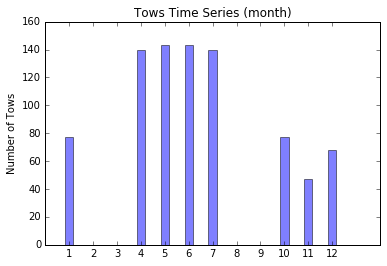

In [68]:
#show dist of tows in calendar year
y_pos = np.arange(1,13)
tows = []
for this_month in range(1,13):
    tows.append( len([ i.to_datetime().month for i in tow_df['pdate'] if i.to_datetime().month == this_month]))
plt.bar(y_pos, tows, bar_width=1, align='center', alpha=0.5)
plt.xticks(y_pos, y_pos)
plt.ylabel('Number of Tows')
plt.title('Tows Time Series (month)')
plt.savefig( '../data/raw/month_routes/Tow_month_distribution.png')
plt.show()